# Source:

Hadi Fanaee-T 

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto 
INESC Porto, Campus da FEUP 
Rua Dr. Roberto Frias, 378 
4200 - 465 Porto, Portugal 

- Original Source: http://capitalbikeshare.com/system-data 
- Weather Information: http://www.freemeteo.com 
- Holiday Schedule: http://dchr.dc.gov/page/holiday-schedule

# Data Set Information:

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

# Attribute Information:

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv 

- instant: record index 
- dteday : date 
- season : season (1:winter, 2:spring, 3:summer, 4:fall) 
- yr : year (0: 2011, 1:2012) 
- mnth : month ( 1 to 12) 
- hr : hour (0 to 23) 
- holiday : weather day is holiday or not (extracted from [Web Link]) 
- weekday : day of the week 
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0. 
+ weathersit : 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale) 
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) 
- hum: Normalized humidity. The values are divided to 100 (max) 
- windspeed: Normalized wind speed. The values are divided to 67 (max) 
- casual: count of casual users 
- registered: count of registered users 
- cnt: count of total rental bikes including both casual and registered 

# Relevant Papers:

[1] Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, [Web Link].

# Citation Request:

Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, [Web Link]. 

>@article{ 
year={2013}, 
issn={2192-6352}, 
journal={Progress in Artificial Intelligence}, 
doi={10.1007/s13748-013-0040-3}, 
title={Event labeling combining ensemble detectors and background knowledge}, 
url={[Web Link]}, 
publisher={Springer Berlin Heidelberg}, 
keywords={Event labeling; Event detection; Ensemble learning; Background knowledge}, 
author={Fanaee-T, Hadi and Gama, Joao}, 
pages={1-15} 
}

# Import Modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor,IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from IPython.core.display import HTML
%matplotlib inline

In [2]:
sns.set_theme(palette="Dark2",context="paper")

# Load Data file

In [3]:
df = pd.read_csv('Bike-Sharing-Dataset/hour.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


# Bike Rental Count in Hours for 2012

<img src="BikeRentalCount.png" width="400" height="400"/>

* screenshot of image taken from reference at the begining of the notebook 

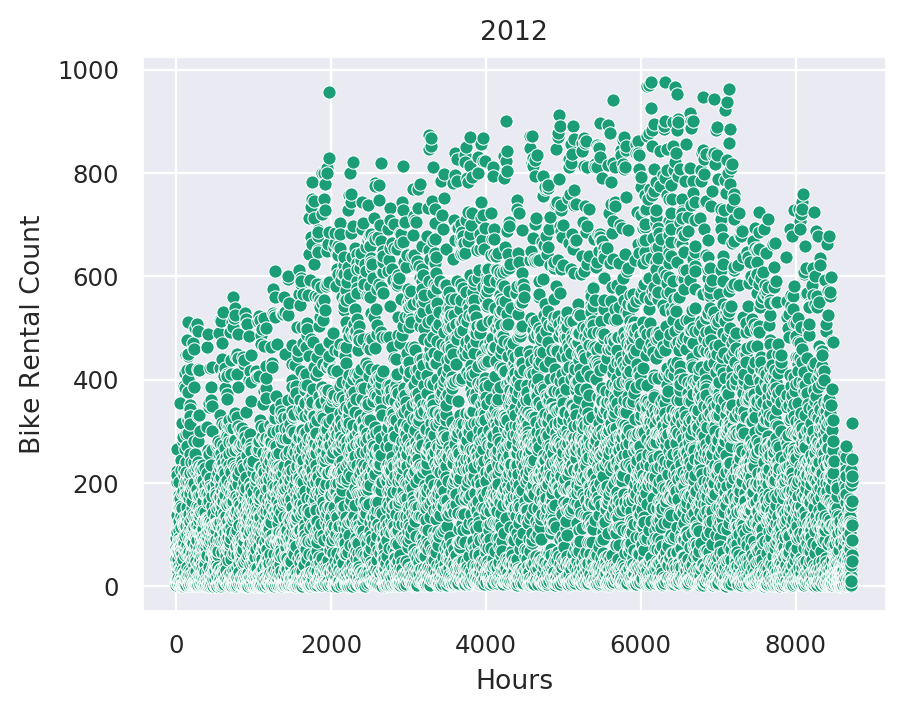

In [4]:
yr_idx = (df["yr"] == 1)
cnt = df["cnt"][yr_idx]
hours = list(range(len(cnt)))
fig,ax = plt.subplots()
sns.scatterplot(x=hours,y=cnt)
ax.set(xlabel="Hours",ylabel="Bike Rental Count",title="2012")
plt.show()

# Load Data set into features and output variables X and y

In [5]:
# Want to exclude object type columns 
columns = [col for col in df.columns.tolist()
               if df[col].dtype in ("float64","int64")]

# full data set 
X = df[columns].drop(columns=["cnt"])
y = df['cnt']

# Principle Component Analysis
Perform feature scaling on data set and then use the scaled data set to do principle component analysis. I will choose the highest dimension such that 95% of the variance is retained. 

From the docs:
>class sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
>
> Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

In [6]:
# feature scaling 
X = StandardScaler().fit_transform(X)
# principle component analysis 
pca = PCA(n_components=len(columns)-1)
pca.fit(X)
variance = 100*(1 - pca.explained_variance_ratio_)
np.column_stack((range(len(variance)),variance))
ncomp = np.argmax(variance[variance<=95])+1
pca = PCA(n_components=ncomp)
pca.fit(X)
print("original shape = ",X.shape)
print("reduced shape = ",pca.transform(X).shape)

original shape =  (17379, 15)
reduced shape =  (17379, 9)


# Extract Training, Validation, and Test Set

In [7]:
# splits 
Xtrain,Xcv,ytrain,ycv = train_test_split(pca.transform(X),
                                         y,
                                         test_size=0.2)
Xtrain,Xtest,ytrain,ytest = train_test_split(Xtrain,
                                             ytrain,
                                             test_size=len(ycv)/(1.0*len(ytrain)))

# check percentages 
ntrain = len(ytrain)
ntest = len(ytest)
ncv = len(ycv)
ntot = len(y)
print("train percentage = ",ntrain/(1.0*ntot))
print("test percentage = ",ntest/(1.0*ntot))
print("cross validation percentage = ",ncv/(1.0*ntot))

train percentage =  0.5999769837159791
test percentage =  0.20001150814201046
cross validation percentage =  0.20001150814201046


# Test Different Models with PCA 

In [8]:
def run(X,y,estimator,*args,**kwargs):
    model = estimator(*args,**kwargs)
    model.fit(X,y)
    return model

In [9]:
alpha = (0.0001,0.001,0.01,0.1,1,10)
models = [run(Xtrain,ytrain,SGDRegressor,alpha=a) for a in alpha]
_R2 = [m.score(Xcv,ycv) for m in models ]
idx = _R2.index(max(_R2))
print("Best of SGDRegressor with PCA")
print("\tTrain: (alpha,R2) = (%g,%g) "%(alpha[idx],models[idx].score(Xtrain,ytrain)))
print("\tTest: (alpha,R2) = (%g,%g) "%(alpha[idx],models[idx].score(Xtest,ytest)))
print("\tFull: (alpha,R2) = (%g,%g) "%(alpha[idx],models[idx].score(pca.transform(X),y)))

Best of SGDRegressor with PCA
	Train: (alpha,R2) = (0.0001,0.767677) 
	Test: (alpha,R2) = (0.0001,0.766706) 
	Full: (alpha,R2) = (0.0001,0.76721) 


Best of DecisionTreeRegressor with PCA 
	Train: (depth,R2) = (12,0.950359) 
	Test: (depth,R2) = (12,0.821692) 
	Full: (depth,R2) = (12,0.900181) 


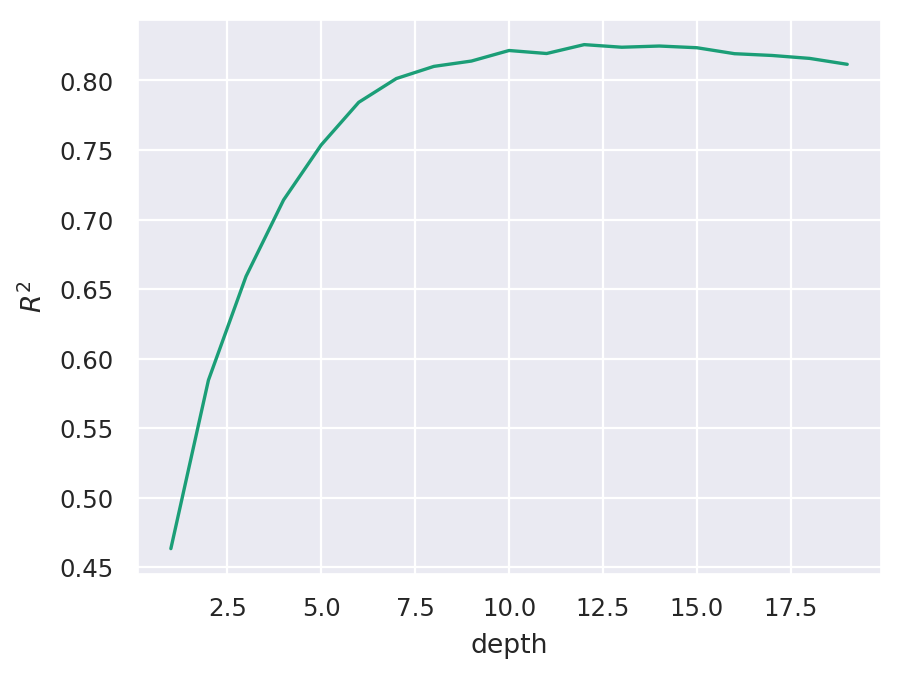

In [10]:
depth = list(range(1,20))
models = [run(Xtrain,ytrain,DecisionTreeRegressor,max_depth=d) for d in depth] 
_R2 = [m.score(Xcv,ycv) for m in models ]
idx = _R2.index(max(_R2))
R2 = models[idx].score(Xtest,ytest)
print("Best of DecisionTreeRegressor with PCA ")
print("\tTrain: (depth,R2) = (%g,%g) "%(depth[idx], models[idx].score(Xtrain,ytrain)))
print("\tTest: (depth,R2) = (%g,%g) "%(depth[idx], models[idx].score(Xtest,ytest)))
print("\tFull: (depth,R2) = (%g,%g) "%(depth[idx],models[idx].score(pca.transform(X),y)))
fig,ax = plt.subplots()
sns.lineplot(x=depth,y=_R2)
ax.set(xlabel="depth",ylabel="$R^2$")
plt.show()

# Test without PCA 

In [11]:
# splits 
Xtrain,Xcv,ytrain,ycv = train_test_split(X,
                                         y,
                                         test_size=0.2)
Xtrain,Xtest,ytrain,ytest = train_test_split(Xtrain,
                                             ytrain,
                                             test_size=len(ycv)/(1.0*len(ytrain)))


alpha = (0.0001,0.001,0.01,0.1,1,10)
models = [run(Xtrain,ytrain,SGDRegressor,alpha=a) for a in alpha]
_R2 = [m.score(Xcv,ycv) for m in models ]
idx = _R2.index(max(_R2))
print("Best of SGDRegressor without PCA")
print("\tTrain: (alpha,R2) = (%g,%g) "%(alpha[idx],models[idx].score(Xtrain,ytrain)))
print("\tTest: (alpha,R2) = (%g,%g) "%(alpha[idx],models[idx].score(Xtest,ytest)))
print("\tFull: (depth,R2) = (%g,%g) "%(alpha[idx],models[idx].score(X,y)))

depth = list(range(1,20))
models = [run(Xtrain,ytrain,DecisionTreeRegressor,max_depth=d) for d in depth] 
_R2 = [m.score(Xcv,ycv) for m in models ]
idx = _R2.index(max(_R2))
print("Best of DecisionTreeRegressor without PCA")
print("\tTrain: (depth,R2) = (%g,%g) "%(depth[idx], models[idx].score(Xtrain,ytrain)))
print("\tTest: (depth,R2) = (%g,%g) "%(depth[idx], models[idx].score(Xtest,ytest)))
print("\tFull: (depth,R2) = (%g,%g) "%(depth[idx],models[idx].score(X,y)))

Best of SGDRegressor without PCA
	Train: (alpha,R2) = (0.0001,1) 
	Test: (alpha,R2) = (0.0001,1) 
	Full: (depth,R2) = (0.0001,1) 
Best of DecisionTreeRegressor without PCA
	Train: (depth,R2) = (16,1) 
	Test: (depth,R2) = (16,0.998799) 
	Full: (depth,R2) = (16,0.99957) 


# Anomaly Detection
https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1

In [12]:
# the data is highly sckewed with skewness > 1 
print("Skewness = ",df["cnt"].skew())
# kurtosis > 0 (leptokurtic distrobution) 
print("Kurtosis = ",df["cnt"].kurt())
df["cnt"].describe()

Skewness =  1.2774116037490577
Kurtosis =  1.4172032806553756


count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

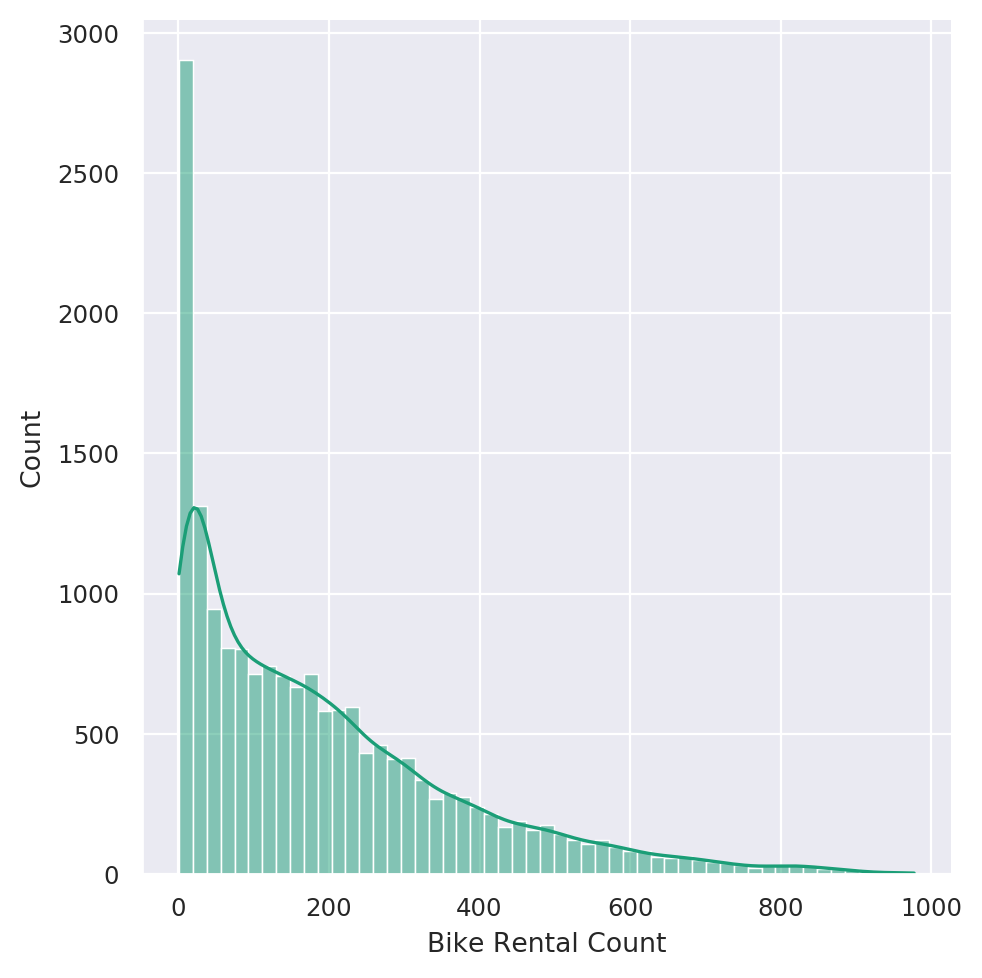

In [13]:
sns.displot(data=df,x="cnt",kde=True)
plt.xlabel('Bike Rental Count')
plt.show()

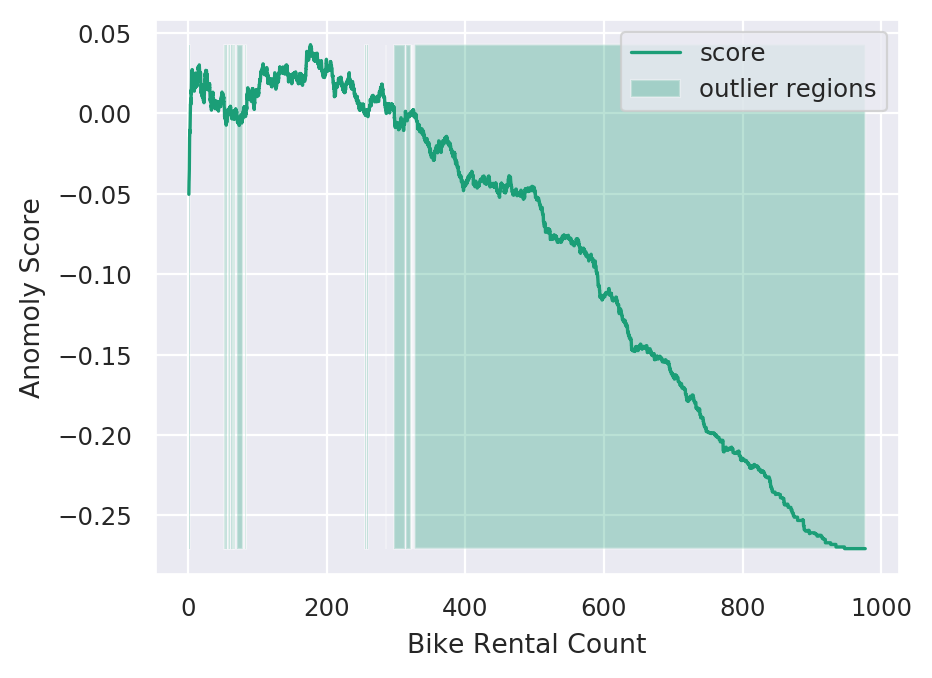

In [14]:
iso_for = IsolationForest(n_estimators=100)
iso_for.fit(df['cnt'].values.reshape(-1,1))
x = np.linspace(df['cnt'].min(),df['cnt'].max(),len(df)).reshape(-1,1)
anomaly_score = iso_for.decision_function(x)
outlier = iso_for.predict(x)

# majority of the outlier regions are near the right tail of the distribution 
# can be multiple regions where outlier is -1
fig,ax = plt.subplots()
ax.plot(x,anomaly_score,label='score')
ax.fill_between(x.T[0],np.min(anomaly_score),np.max(anomaly_score),where=outlier==-1,alpha=0.3,label='outlier regions')
ax.set(xlabel='Bike Rental Count',ylabel="Anomoly Score")
plt.legend()
plt.show()

# Combine Principle Component Analysis, Feature Scaling, and Anomaly Detection 

In [15]:
# Use previously defined pca 
Xpca = pca.transform(X)
# Remove anomalies from data 
Xpca_anomaly_free = Xpca[outlier>0]
y_anomaly_free = y[outlier>0]
print(len(y_anomaly_free),len(y))

4889 17379


In [16]:
# splits 
Xtrain,Xcv,ytrain,ycv = train_test_split(Xpca_anomaly_free,
                                         y_anomaly_free,
                                         test_size=0.2)
Xtrain,Xtest,ytrain,ytest = train_test_split(Xtrain,
                                             ytrain,
                                             test_size=len(ycv)/(1.0*len(ytrain)))
alpha = (0.0001,0.001,0.01,0.1,1,10)
models = [run(Xtrain,ytrain,SGDRegressor,alpha=a) for a in alpha]
_R2 = [m.score(Xcv,ycv) for m in models ]
idx = _R2.index(max(_R2))
print("Best of SGDRegressor with PCA and anomaly detection")
print("\tTrain: (alpha,R2) = (%g,%g) "%(alpha[idx],models[idx].score(Xtrain,ytrain)))
print("\tTest: (alpha,R2) = (%g,%g) "%(alpha[idx],models[idx].score(Xtest,ytest)))
print("\tFull: (alpha,R2) = (%g,%g) "%(alpha[idx],models[idx].score(Xpca_anomaly_free,y_anomaly_free)))

Best of SGDRegressor with PCA and anomaly detection
	Train: (alpha,R2) = (0.0001,0.933593) 
	Test: (alpha,R2) = (0.0001,0.930546) 
	Full: (alpha,R2) = (0.0001,0.931899) 
